# Flight delays and cancellations


### Student 1 (first half presentation)
Name : Zhijian (Jane) Xu
<br>Group : intermediate
### Student 2 (second half presentation)
Name : Grégoire Virepinte
<br>Group : intermediate
### Data name : Flight Delays and Cancellations
### Data URL : https://www.kaggle.com/usdot/flight-delays
Note: another, more presentable version for this notebook is available here https://plot.ly/~janeXU/21/flight-delays-and-cancellations-authors/

### Short summary of the project and datasource :
The data was collected and published by the DOT's Bureau of Transportation Statistics. It provides information about every domestic flight operated by large carriers in the United States in 2015, and tracks their performance.

Our aim in this document will be to explore this data, identify which factors will result in a larger amount of delay upon arrival, and eventually attempt to predict how likely it is that a flight will be late or not based on all the prior information that we can find.

### Aims : 
Our aim in this document will be:
- To explore this data,
- To identify which factors will result in a larger amount of delay upon arrival,
- And, eventually, to attempt to predict how likely it is that a flight will be late or not based on all the prior information that we can find.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import time
import sklearn
import urllib

import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go 
import plotly.figure_factory as ff

from sklearn.preprocessing import OneHotEncoder
from scipy import sparse 
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

%matplotlib inline

C:\Users\Grégoire\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [2]:
# set token to plotly
tls.set_credentials_file(username='janeXU', api_key='ya6M3F6zUuNKBO9MYgRR')

### Download
We initially downloaded the dataset from Kaggle. However, since we need to be authentified to download a dataset on Kaggle, we could not download it directly from there on Python.

Instead, we used a workaround:
- We downloaded the data from Kaggle manually,
- We uploaded it onto a Github directory,
- We downloaded it again, this time directly on Python.

However, one of the files was too big to be uploaded directly on Github (> 500 MB, while the limit on Github is 100 MB), so we split this file into several chunks before uploading every separate chunk onto Github.

In [3]:
## Downloading the files ##
## This step might take a while (take two or three minutes, depending on the computer and the internet environment ) ##

file_names = ['airlines.csv'] + ['flights' + str(i) + '.csv' for i in range(1, 13)] + ['airports.csv']
# Definition of the name of the files we download

urllib.request.urlretrieve("https://github.com/Jamaneth/flight_delays_usa/raw/master/airlines.csv", file_names[0])
urllib.request.urlretrieve("https://github.com/Jamaneth/flight_delays_usa/raw/master/airports.csv", file_names[-1])

airlines = pd.read_table(file_names[0], sep = ',')
airports = pd.read_table(file_names[-1], sep = ',')

urllib.request.urlretrieve("https://github.com/Jamaneth/flight_delays_usa/raw/master/flights1.csv", file_names[1])

# To import the biggest document (flights), we start by uploading the first file separately (flight1),
# and then we add every other chunk to that initial file in order to restore our initial dataset.
flights = pd.read_table(file_names[1], sep = ',')

for ind in range(2, 13):
    
    urllib.request.urlretrieve("https://github.com/Jamaneth/flight_delays_usa/raw/master/flights"\
                               + str(ind) + ".csv", file_names[ind])
    
    flights = flights.append(pd.read_table(file_names[ind], sep = ','), ignore_index = True)
    # The ignore_index variable is set to True, which means that the index does not loop back to 1
    # for every chunk that we add

# 1. Description of the database

Our main dataset is contained in the file `flights.csv`.

The other two files (`airlines.csv` and `airports.csv`) are very small databases that give us more details about some variables in our dataset:
- `airlines.csv` allows us to retrieve the full name of the airlines, given their IATA code (two letters),
- `airports.csv` allows us to find the full name of every airport, the city in which it is located (along with its state and country), and its latitude and longitude.

In [4]:
print ('The dimension of the dataframe airlines is' , airlines.shape)
airlines

The dimension of the dataframe airlines is (14, 2)


,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [5]:
print ('The dimension of the dataframe airports is' , airports.shape)
airports[:5]

The dimension of the dataframe airports is (322, 7)


,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [6]:
print ('The dimension of the dataframe flights is' , flights.shape)
flights[:10]

The dimension of the dataframe flights is (5819079, 31)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5,2015,1,1,4,DL,806,N3730B,SFO,MSP,25,...,610.0,8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
6,2015,1,1,4,NK,612,N635NK,LAS,MSP,25,...,509.0,-17.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
7,2015,1,1,4,US,2013,N584UW,LAX,CLT,30,...,753.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
8,2015,1,1,4,AA,1112,N3LAAA,SFO,DFW,30,...,532.0,-13.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
9,2015,1,1,4,DL,1173,N826DN,LAS,ATL,30,...,656.0,-15.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In this dataset, we have information about 5,819,079 flights that took place in the United States in 2015, for 31 variables.

In [7]:
flights.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

The `flights` dataset, which is going to be our main dataset, includes three variables that refer to the other two datasets: `AIRLINE`, `ORIGIN_AIRPORT`, and `DESTINATION_AIRPORT`.

The airlines and airports seem to be stored in `flights` as IATA codes: for this reason, we set the index of `airports` and `airlines` as `IATA_CODE`.

In [8]:
# Set indexes for the other databases
airlines.set_index('IATA_CODE', inplace = True)
airports.set_index('IATA_CODE', inplace = True)

## 1.1. More information about the variables in the `flights` database

A source for some of this information can be found <a href = "https://www.transtats.bts.gov/Oneway.asp?Field_Desc=Specifies%20The%20Reason%20For%20Cancellation&Field_Type=Char&Sel_Cat=CANCELLATION_CODE&Lookup_Table=L_CANCELLATION&Sel_Var=Cancelled&Sel_Stat=Sum&Data_Type=CAT&Percent_Flag=0&Display_Flag=0">here</a>.

### 1.1.1. YEAR, MONTH, DAY
Self-explanatory.

### 1.1.2. DAY_OF_WEEK
A number from 1 to 7. 1 corresponds to Monday, 2 corresponds to Tuesday...

### 1.1.3. AIRLINE
One of fourteen airlines (the full names of which can be found in the spreadsheet `airlines.csv`).

### 1.1.4. FLIGHT_NUMBER
Self-explanatory.

### 1.1.5. TAIL_NUMBER
An identifier that is unique for every aircraft.

### 1.1.6. ORIGIN_AIRPORT, DESTINATION_AIRPORT
The full names can be found in the spreadsheet called `airports.csv`.

### 1.1.7. SCHEDULED_DEPARTURE, DEPARTURE_TIME
Note: the time was not stored in a very clean way. The values take the form of a number with four digits: the first two digits give the hour (hh)(modulo 2400), and the other two give the minutes (mm).
For example, a value of `5` in `SCHEDULED_DEPARTURE` means that the departure was actually scheduled at 00:05.

### 1.1.8. DEPARTURE_DELAY
Difference between DEPARTURE_TIME and SCHEDULED_DEPARTURE. Can be negative if the plane leaves before schedule.

### 1.1.9. TAXI_OUT
Amount of time between when the airplane leaves the gate and when it takes off. This value is given in minutes.

### 1.1.10. WHEELS_OFF
Time at which the plane takes off. The value is stored as four digits (hhmm), as for `SCHEDULED_DEPARTURE` and `DEPARTURE_TIME`.

Note: `WHEELS_OFF` = `DEPARTURE_TIME` + `TAXI_OUT` (modulo 2400).

### 1.1.11. SCHEDULED_TIME, ELAPSED_TIME, AIR_TIME
- `SCHEDULED_TIME`: expected duration of the flight. This takes into account the taxi-out and the taxi-in.
- `ELAPSED_TIME`: actual duration of the flight. This also takes into account the taxi-out and the taxi-in.
- `AIR_TIME`: this is the amount of time during which the plane was *actually* flying.

The values are given in minutes.

### 1.1.12. WHEELS_ON
Time at which the plane lands (format: hhmm).

**NOTE: This includes the time difference between the two airports.**

### 1.1.13. TAXI_IN
Similar to `TAXI_OUT`.

### 1.1.14. SCHEDULED_ARRIVAL, ARRIVAL_TIME
Again, the format is (hhmm).

### 1.1.15. ARRIVAL DELAY
`ARRIVAL_DELAY` = `ARRIVAL_TIME` - `SCHEDULED_ARRIVAL`.

This is the delay on arrival, and the variable that we will be trying to predict. Note that it may be negative if the plane lands early.

### 1.1.16. DIVERTED, CANCELLED
They take the value 1 if the plane has respectively been diverted or cancelled, and 0 otherwise.

### 1.1.17. CANCELLATION_REASONS
The values for this variable can take the values "A", "B", "C", or "D". They correspond to the following code:
- A: Carrier. The cause of the cancellation or delay was due to circumstances within the airline's control (e.g. maintenance or crew problems, aircraft cleaning, baggage loading, fueling, etc.).
- B: Weather. Significant meteorological conditions (actual or forecasted) that, in the judgment of the carrier, delays or prevents the operation of a flight such as tornado, blizzard or hurricane.
- C: National Air System. Delays and cancellations attributable to the national aviation system that refer to a broad set of conditions, such as non-extreme weather conditions, airport operations, heavy traffic volume, and air traffic control.
- D: Security. Delays or cancellations caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.

### 1.1.18. AIR_SYSTEM_DELAY, SECURITY_DELAY, AIRLINE_DELAY, LATE_AIRCRAFT_DELAY, WEATHER_DELAY
Those five variables give five possible explanations for the delay, and the amount of delay caused by each reason in minutes.

# 2. Explore and filter the data

## 2.1. Dealing with the missing values

### 2.1.1. Checking the missing data

In [9]:
# Add code which gives all the missing values for each column
for col in flights:
    print ("%d missing values are detected in the column %s" 
           % (flights[col].isnull().sum().sum(), col))

0 missing values are detected in the column YEAR
0 missing values are detected in the column MONTH
0 missing values are detected in the column DAY
0 missing values are detected in the column DAY_OF_WEEK
0 missing values are detected in the column AIRLINE
0 missing values are detected in the column FLIGHT_NUMBER
14721 missing values are detected in the column TAIL_NUMBER
0 missing values are detected in the column ORIGIN_AIRPORT
0 missing values are detected in the column DESTINATION_AIRPORT
0 missing values are detected in the column SCHEDULED_DEPARTURE
86153 missing values are detected in the column DEPARTURE_TIME
86153 missing values are detected in the column DEPARTURE_DELAY
89047 missing values are detected in the column TAXI_OUT
89047 missing values are detected in the column WHEELS_OFF
6 missing values are detected in the column SCHEDULED_TIME
105071 missing values are detected in the column ELAPSED_TIME
105071 missing values are detected in the column AIR_TIME
0 missing values a

We note two things:
- There is no missing data in the **flight schedule information**, which includes FLIGHT_NUMBER, ORIGIN_AIRPORT, DESTINATION_AIRPORT, DESTINATION_AIRPORT, DISTANCE, SCHEDULED_DEPARTURE, SCHEDULED_ARRIVAL, DIVERTED, CANCELLED as well as the date YEAR, MONTH, DAY, DAY_OF_WEEK.
- There is, however, missing data for other such variables as `TAIL_NUMBER`, `DEPARTURE_TIME`, `DEPARTURE_DELAY`, `ARRIVAL_TIME`, or `ARRIVAL_DELAY`.

This may be because of the flights that were cancelled or diverted: since those flights never took off or did not land in the right airport, there is no reason for them to have that information – because in those cases, these categories do not apply.

As a consequence, we are going to check the missing data for all flights that were not diverted or cancelled.

### 2.1.2. Missing data due to cancelled and diverted flights 

In [10]:
# Add code which gives all the missing values for each column after filtering out the diverted and cancelled flights
for col in flights[(flights.CANCELLED == 0) & (flights.DIVERTED == 0)]:
    print ("%d missing values are detected in the column %s" 
           % (flights[(flights.CANCELLED == 0) & (flights.DIVERTED == 0)][col].isnull().sum().sum(), col))

0 missing values are detected in the column YEAR
0 missing values are detected in the column MONTH
0 missing values are detected in the column DAY
0 missing values are detected in the column DAY_OF_WEEK
0 missing values are detected in the column AIRLINE
0 missing values are detected in the column FLIGHT_NUMBER
0 missing values are detected in the column TAIL_NUMBER
0 missing values are detected in the column ORIGIN_AIRPORT
0 missing values are detected in the column DESTINATION_AIRPORT
0 missing values are detected in the column SCHEDULED_DEPARTURE
0 missing values are detected in the column DEPARTURE_TIME
0 missing values are detected in the column DEPARTURE_DELAY
0 missing values are detected in the column TAXI_OUT
0 missing values are detected in the column WHEELS_OFF
0 missing values are detected in the column SCHEDULED_TIME
0 missing values are detected in the column ELAPSED_TIME
0 missing values are detected in the column AIR_TIME
0 missing values are detected in the column DIST

We can see that when we filter out the diverted and the cancelled flights, there is no more missing data for most columns (except `CANCELLATION_REASON`, `AIR_SYSTEM_DELAY`, `SECURITY_DELAY`, `AIRLINE_DELAY`, `LATE_AIRCRAFT_DELAY` and `WEATHER_DELAY`), which was in line with our expectations.

In [11]:
#the number of cancelled flights
print("The number of cancelled flights is " + str(flights.shape[0]*np.mean(flights.CANCELLED)))
#the number of cancellation reasons 
print("The number of cancellation reasons is " + str(flights.shape[0]-flights.CANCELLATION_REASON.isnull().sum().sum()))

The number of cancelled flights is 89884.0
The number of cancellation reasons is 89884


We find that the number of cancelled flights and the number of cancellation reasons is exactly the same, suggesting that only the cancelled flights have cancellatin reasons, which is reasonable.


### 2.1.3. Definition of a delay and missing data due to low delays
The dataset seems to consider that a plane is delayed when it lands 15 minutes or more after its scheduled time, since we do not get a detailled explanation for any delay smaller than 15 minutes.

Indeed, if we try to find the maximum delay for which there is a missing value in the column `AIR_SYSTEM_DELAY`, we find that:

In [12]:
max(flights.ARRIVAL_DELAY[pd.isnull(flights.AIR_SYSTEM_DELAY)])

14.0

And conversely, if we try to find the smallest delay for which there is a detailled explanation, we find that:

In [13]:
min(flights.ARRIVAL_DELAY[pd.isnull(flights.AIR_SYSTEM_DELAY) == False])

15.0

This suggests that the creators of the dataset considered that **a plane is delayed if and only if it lands 15 minutes after its scheduled time**. For the sake of consistency, we will keep this same definition for the rest of this document.     

Additionally, we use our definition of delay to explore the missing values in delay reasons break down. We check the number of the delayed flights (by our definition) is equal to the number of reason for delay breakdown, indicating that all delayed flights have  their delay reasons.

In [14]:
#the number of delayed flights
print (flights['ARRIVAL_DELAY'][flights['ARRIVAL_DELAY'] >= 15].count())
#the number of delay reasons breakdown
print (flights.shape[0] - flights.AIR_SYSTEM_DELAY.isnull().sum().sum())

1063439
1063439


In [15]:
# Cancelled data does not have delay break down 
flights.groupby(['CANCELLED'])['AIR_SYSTEM_DELAY'].count()

CANCELLED
0    1063439
1          0
Name: AIR_SYSTEM_DELAY, dtype: int64

In [16]:
# Diverted data does not have delay break down
flights.groupby(['DIVERTED'])['AIR_SYSTEM_DELAY'].count()

DIVERTED
0    1063439
1          0
Name: AIR_SYSTEM_DELAY, dtype: int64

## 2.2. An initial filter of the data

### 2.2.1. An overview of the less crucial variables
- The column `YEAR` is redundant, since every single flight has taken place in 2015: it does not add any information at all.
- `TAIL_NUMBER`: this variable identifies the exact plane that has been used for a specific flight. Since this is not a very descriptive variable, we may discard it.
- `WHEELS_OFF` and `WHEELS_ON`: this information in particular seems to be redundant. This does not have an explanatory value in itself, given that we already have `DEPARTURE_TIME` and `ARRIVAL_TIME`, plus the actual duration of the flight.
- `TAXI_IN` and `TAXI_OUT`
- `DIVERTED`, `CANCELLED` and `CANCELLATION_REASON`: our aim in this document is to study the arrival delay of airplanes. For this reason, we have to filter the cancelled and diverted flights out of the dataset - in which case those three variables do not carry any more information and we notice that the cancelled and diverted flights are not caused from the delays from the dataset. 

In [17]:
# Reduce the number of variables

flights = flights.drop(['YEAR', 'TAIL_NUMBER', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'TAXI_OUT'], axis = 1)

# Filter the numebr of observations 

flights = flights.query('CANCELLED == 0 & DIVERTED == 0')

flights = flights.drop(['CANCELLED', 'CANCELLATION_REASON', 'DIVERTED'], axis = 1)

In [18]:
flights.shape

(5714008, 22)

### 2.2.2. Consistency of the data format: the case of the October airports
By exploring the data a bit, we notice that the airport codes for `ORIGIN_AIRPORT` and `DESTINATION_AIRPORT` are not consistent. Most of the times, they follow the standard established in the file `airport.csv`. However, for all flights that have taken off in October, the airports are designed by a five-digit code.

In [19]:
flights[flights.MONTH == 10].ORIGIN_AIRPORT[:10]

4385712    14747
4385713    14771
4385714    12889
4385715    12892
4385716    14771
4385717    14771
4385718    12892
4385719    14869
4385720    12892
4385721    12892
Name: ORIGIN_AIRPORT, dtype: object

In [20]:
flights[flights.MONTH == 10].DESTINATION_AIRPORT[:10]

4385712    11298
4385713    13487
4385714    13487
4385715    13303
4385716    11057
4385717    13930
4385718    13930
4385719    11057
4385720    11298
4385721    13487
Name: DESTINATION_AIRPORT, dtype: object

Those codes are not included in the `airports` nomenclature: therefore, in this current state, they are similar to missing data. However, in this section, we are going to attempt to infer those codes based on the information that is already contained in the database. The aim will be to map every 5-digit code to a known IATA code.

The idea to solve this problem will be to identify regular flights that happen all year long between the same origin airport and the same destination airport. We identify those flights based on two pieces of information:
- Their flight number,
- Their scheduled time.

Indeed, even though the flight number is not precise enough, we find that the combination (FLIGHT_NUMBER, SCHEDULED_TIME) is often precise enough to identify a specific flight.

To give an example, if we filter the database to keep only the flights with flight number 2342 and scheduled departure time 11:59 pm, we find:

In [21]:
flights[(flights.FLIGHT_NUMBER == 2342) & (flights.SCHEDULED_DEPARTURE == 2359)]

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,...,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
2453335,6,4,4,AA,2342,DEN,MIA,2359,21.0,22.0,...,201.0,1709,550,558.0,8.0,NaN,NaN,NaN,NaN,NaN
2470602,6,5,5,AA,2342,DEN,MIA,2359,26.0,27.0,...,201.0,1709,550,614.0,24.0,0.0,0.0,4.0,20.0,0.0
2484842,6,6,6,AA,2342,DEN,MIA,2359,2359.0,0.0,...,201.0,1709,550,537.0,-13.0,NaN,NaN,NaN,NaN,NaN
2501514,6,7,7,AA,2342,DEN,MIA,2359,2359.0,0.0,...,199.0,1709,550,539.0,-11.0,NaN,NaN,NaN,NaN,NaN
2518830,6,8,1,AA,2342,DEN,MIA,2359,1.0,2.0,...,195.0,1709,550,532.0,-18.0,NaN,NaN,NaN,NaN,NaN
2535952,6,9,2,AA,2342,DEN,MIA,2359,6.0,7.0,...,202.0,1709,550,546.0,-4.0,NaN,NaN,NaN,NaN,NaN
2553116,6,10,3,AA,2342,DEN,MIA,2359,2356.0,-3.0,...,211.0,1709,550,549.0,-1.0,NaN,NaN,NaN,NaN,NaN
2570503,6,11,4,AA,2342,DEN,MIA,2359,45.0,46.0,...,220.0,1709,550,645.0,55.0,9.0,0.0,46.0,0.0,0.0
2587941,6,12,5,AA,2342,DEN,MIA,2359,2358.0,-1.0,...,213.0,1709,550,547.0,-3.0,NaN,NaN,NaN,NaN,NaN
2602725,6,13,6,AA,2342,DEN,MIA,2359,2356.0,-3.0,...,199.0,1709,550,529.0,-21.0,NaN,NaN,NaN,NaN,NaN


We can see that this combination (`FLIGHT_NUMBER`, `SCHEDULED_DEPARTURE`) corresponds to a unique flight by American Airlines that goes from Denver International Airport to Miami International Airport on a daily basis, from June 4th onwards. It is therefore reasonable to say that for this particular query, the two unknown airports in October will be respectively DEN and MIA.

Therefore, once we have identified such a flight, we can replace the unknown codes by the airports that we found, and try again for a different unknown code.

In [22]:
# First step: get the list of all unique airport values for October

origin = flights.query("MONTH == 10").ORIGIN_AIRPORT.unique()
dest = flights.query("MONTH == 10").DESTINATION_AIRPORT.unique()

print("Number of origin airports:", len(origin))
print("Number of destination airports:", len(dest))


Number of origin airports: 306
Number of destination airports: 307


For October, there are 306 different airports in the `ORIGIN_AIRPORT` column, and 307 airports in the `DESTINATION_AIRPORT` column.

In [23]:
airport_dict = dict(zip(list(dest),[np.NaN] * len(dest)))

We are going to run the same algorithm twice in order to fill the airport dictionary:
- The first time will be over the `DESTINATION_AIRPORT` column,
- The second time will be over the `ORIGIN_AIRPORT` column in order to try to find more information about the data that is still missing.

Please note that the following code may take a while to run (> 2 minutes, depending on the computer).

In [24]:
def airport_finder(column_name, airport_dict = airport_dict):
    
    start_time = time.time()
    
    for key in airport_dict: # Iterates over all airport names (format: 5 digits)
        if not airport_dict[key] is np.NaN: # Check that we do not know the corresponding IATA_CODE yet
            continue
        
        else:
            index_list = np.array(flights[column_name][flights[column_name] == key].index)
            # find the index of all rows for which the destination airport is the airport searched
    
            for key_index in index_list:
        
                query = flights[(flights.SCHEDULED_DEPARTURE == flights.SCHEDULED_DEPARTURE[key_index])\
                               & (flights.FLIGHT_NUMBER == flights.FLIGHT_NUMBER[key_index])\
                               & (flights.MONTH != 10)]
                # Filter the database with the same scheduled departure and same flight number as the row found
                # We remove from the query flights that took off in October, to get cleaner results 
        
                if len(query[column_name].unique()) != 1: #  This here in order to avoid confusion: if more
                    continue                             # than one airport is identified here, then we have
                                                         # not identified our unknown code with 100% certainty.
            
                else:
                    airport_dict[key] = query[column_name].unique()[0]
                    break

airport_finder("DESTINATION_AIRPORT")
airport_finder("ORIGIN_AIRPORT")

In [25]:
print('Airports missing:', list(airport_dict.values()).count(np.NaN))

Airports missing: 2


There are now only two airports missing (down from 307).

Now that we finally have this dictionary, we replace the values in the database.

In [26]:
# This replaces all keys in the dictionary by the corresponding values
# for the columns 'DESTINATION_AIRPORT' and 'ORIGIN_AIRPORT'

flights[flights.MONTH == 10] = flights[flights.MONTH == 10].replace(
    {'DESTINATION_AIRPORT':airport_dict, 'ORIGIN_AIRPORT':airport_dict})

In [27]:
print('Flights with origin airport missing:', len(flights[pd.isnull(flights.ORIGIN_AIRPORT)]))
print('Flights with destination airport missing:', len(flights[pd.isnull(flights.DESTINATION_AIRPORT)]))

Flights with origin airport missing: 62
Flights with destination airport missing: 62


There are now slightly more than a hundred flights with an unknown airport, which is a huge improvement compared to the initial situation.

### 2.2.3. Filter the number of airports

In [28]:
print('Number of departure airports:', len(flights.ORIGIN_AIRPORT.unique()))
print('Number of destination airports:', len(flights.DESTINATION_AIRPORT.unique()))

Number of departure airports: 323
Number of destination airports: 323


We notice that there are more than 300 airports in our dataset, some with a fairly low amount of flights. Since `ORIGIN_AIRPORT` is a categorical variables, we would like to reduce the number of airports taken into account into our analysis.

Indeed, we suspect that the origin airport will play a strong role when trying to predict the delay, and we would like to remove from our analysis the airports with a low amount of flights (because the information they provide may not be very accurate).

Therefore, we are going to remove the airports with the lowest number of flights, in order to make the analysis a bit more simple, while still retaining at least 95% of the original dataset.

To achieve this, we are going to sort the airports by number of flights, then calculate the cumulative sum based on that ranking. Then, we define a threshold, such that every airport whose cumulative sum is above the threshold will be scraped.

In [29]:
flights = flights.dropna(axis = 0, subset = ('ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'), how = 'any') # Remove the missing
# values for origin and destination airports

airport_count = flights.groupby("ORIGIN_AIRPORT").agg({"ORIGIN_AIRPORT": "count"})

airport_count.columns = ['FLIGHT_COUNT']

airport_count = airport_count.sort_values('FLIGHT_COUNT', ascending = False) # Sort by descending values

airport_count["FLIGHT_COUNT_CUMSUM"] = np.cumsum(airport_count.FLIGHT_COUNT) # Create a new column with the cumulative sum
# of flights

airport_count[:10]

,FLIGHT_COUNT,FLIGHT_COUNT_CUMSUM
ORIGIN_AIRPORT,,
ATL,376015,376015
ORD,304232,680247
DFW,253233,933480
DEN,211479,1144959
LAX,209631,1354590
SFO,159585,1514175
PHX,158436,1672611
IAH,157110,1829721
LAS,144586,1974307


In [30]:
# Here, we define a threshold for the cumulative sum, and we determine the first airport
# that crosses the threshold. The aim is to keep at least 95% of the flights

thresh = 0.95 * airport_count.FLIGHT_COUNT_CUMSUM[-1]

min_airport = [airport for airport in airport_count.index if airport_count.loc[airport].FLIGHT_COUNT_CUMSUM > thresh][0]

Text(0.5,1,'Cumulative number of flights that left from every American airport in 2015')

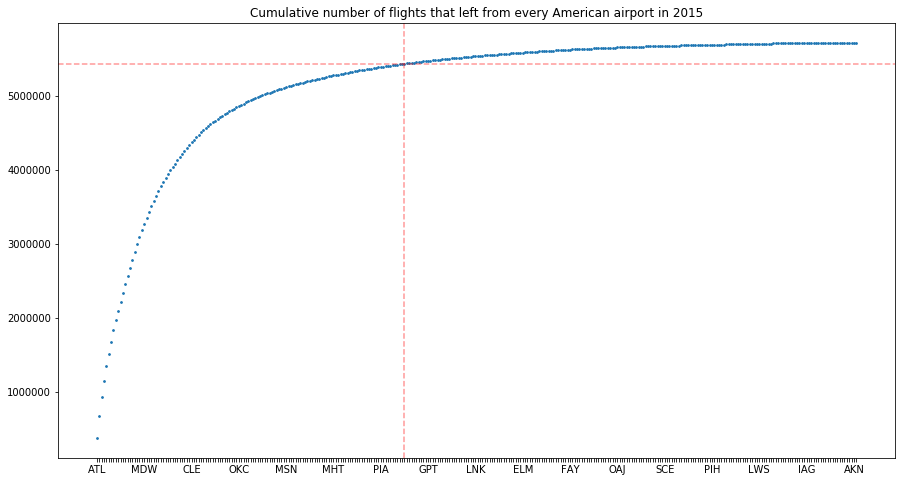

In [31]:
# Now, let us project all of this on a graph

fig, ax = plt.subplots(figsize = (15, 8))

x = range(0, len(airport_count))
plt.xticks(x,[airport if list(airport_count.index).index(airport) % 20 == 0 else "" for airport in airport_count.index])
# This line in order to have a legible x axis with the names of the airports

ax.scatter(x = x,
           y = airport_count.FLIGHT_COUNT_CUMSUM,
          s = 3)

ax.axhline(y = thresh,
           color = 'red',
           alpha = 0.4,
          linestyle = 'dashed')

ax.axvline(x = list(airport_count.index).index(min_airport),
           color = 'red',
           alpha = 0.4,
          linestyle = 'dashed')

ax.set_title("Cumulative number of flights that left from every American airport in 2015")

In [32]:
min_index = list(airport_count.index).index(min_airport)

def_airport = list(airport_count.index[min_index:])

min_index

130

We can see that 95% of the flights in the United States have taken place in just 130 airports. As a consequence, we are going to drop the rest of the airports:
- So that the model can be a bit more simple,
- Because not a lot of flights have taken off of the rest of the airports, which implies that the sample we have for them may not prove to be very representative anyway.

In [33]:
flights = flights.drop(flights[flights.ORIGIN_AIRPORT.isin(def_airport)].index)
flights = flights.drop(flights[flights.DESTINATION_AIRPORT.isin(def_airport)].index)

# 3. Data visualisation

## 3.1. Distribution of the airplane delays

In [34]:
print('Minimum delay:', min(flights.ARRIVAL_DELAY))
print('Maximum delay:', max(flights.ARRIVAL_DELAY))

Minimum delay: -87.0
Maximum delay: 1971.0


Even though the actual range is $[-87, 1971]$, we choose to only represent the plot on the range $[-50, 200]$ in order to have a more legible graph, since there are very few values outside of this range anyway.

**Note:** the red line represents the 15 minute delay, after which a plane is considered to be delayed.

Text(0.5,1,'Airplane delays in the USA in 2015')

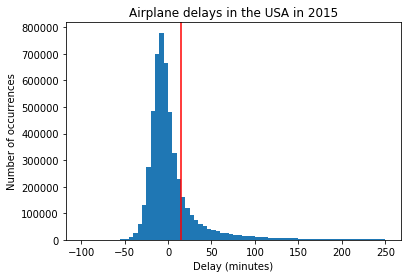

In [35]:
plt.hist(flights.ARRIVAL_DELAY, bins = 70, range = (-100, 250))

plt.axvline(x=15, color = 'red')

plt.xlabel('Delay (minutes)')
plt.ylabel('Number of occurrences')
plt.title('Airplane delays in the USA in 2015')

## 3.2. Relation between `ARRIVAL_DELAY` and six variables
The charts below were mainly generated by *plotly* module, and explore the following relations 
- Relation between Delays and Month of 2015 [`MONTH`]
- Relation between Delays and Day of a Week [`DAY_OF_WEEK`]
- Relation between Delays and Hours of a Day [`DEPARTURE_HOUR`]
- Relation between Delays and Flight Duration [`DURATION`]
- Relation between Delays and Origin Airports [`ORIGIN_AIRPORT`]
- Relation between Delays and Airline Carriers [`AIRLINE`]       

We use the average time of arrival delay and the number of flights with more than 15 minutes arrival delay to refer 'Delays' in the different following figures.

### 3.2.1. Relation between `ARRIVAL_DELAY` and `MONTH` (Annual Trends)

In [36]:
# month of 2015
depdel = flights.groupby(['MONTH'])['DEPARTURE_DELAY'].mean()
arrdel = flights.groupby(['MONTH'])['ARRIVAL_DELAY'].mean()
MonthVolumE = flights.groupby(['MONTH'])['FLIGHT_NUMBER'].count()
#type(depdel)
#depdel.tolist()

linedep = go.Scatter(
    x=list(range(1,13)),
    y= depdel.tolist(),
    name = 'Avg Departure Delay (min)',
     yaxis='y2'
)
linearr = go.Scatter(
    x=list(range(1,13)),
    y= arrdel.tolist(),
    name = 'Avg Arrival Delay (min)',
     yaxis='y2'
)

barvol = go.Bar(
    x=list(range(1,13)),
    y= MonthVolumE.tolist(),
    name = 'Flight Volume',

     marker=dict(
        color='rgb(158,202,225)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5)
    ),
    opacity=0.5     
)

data = go.Data([linedep, linearr, barvol])

layout = dict(title = 'Average Delay by Month',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
              yaxis2=dict (title='Average Delay', overlaying='y',side='right')
             )


fig = go.Figure(data=data, layout=layout)

py.iplot(fig,filename='AverageDelayTime')


High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~janeXU/0 or inside your plot.ly account where it is named 'AverageDelayTime'


- Annual trends in average flight departure and arrival delays show the increase in flight delay in the summer months which peaks in June and in winter holidays. These trends basically correspond to increases in air traffic. Additionally, the average departure delay is lower than the average arrival delay, implies the speed of flights departing late tends to be increased.
- Now, we consider the number of flights with more than 15 minutes arrival delay and the flight volume to create an indicator delay rate (# of delayed flights /flight volume) and it gives the similar pattern. 

In [37]:
# Only consider the number of delays with delay break down, that is Arrival delay  >15 min
# Delay rate #of delays / total number of flights [per month]
MonthVolumE = flights.groupby(['MONTH'])['FLIGHT_NUMBER'].count()
numdel = flights.groupby(['MONTH'])['AIR_SYSTEM_DELAY'].count()
DelayRate = numdel/MonthVolumE*100
linerate = go.Scatter(
    x=list(range(1,13)),
    y= DelayRate.tolist(),
    name = 'Avg Delay Rate (%)'
)

data = go.Data([linerate])

layout = dict(title = 'Delay Rate (%) per Month',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )


fig = go.Figure(data=data, layout=layout)

py.iplot(fig,filename='DelayRate')

### 3.2.2. Relation between `ARRIVAL_DELAY` and `DAY_OF_WEEK` (Weekly Trends)

In [38]:
arrdel = flights.groupby(['DAY_OF_WEEK'])['ARRIVAL_DELAY'].mean()
wkvol = flights.groupby(['DAY_OF_WEEK'])['FLIGHT_NUMBER'].count()


linearr = go.Scatter(
    x=list(range(1,13)),
    y= arrdel.tolist(),
    name = 'Avg Arrival Delay (min)',
     yaxis='y2'
)

barvol = go.Bar(
    x=list(range(1,13)),
    y= wkvol.tolist(),
    name = 'Flight Volume',
    opacity=0.6  
    
)

data = go.Data([linearr, barvol])

layout = dict(title = 'Average Delay by Day of a Week',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
              yaxis2=dict (title='Average Delay', overlaying='y',side='right')
             )


fig = go.Figure(data=data, layout=layout)

py.iplot(fig,filename='avgdaydelay')

- The graph of weekly trends in average flight delay shows the plummet on Saturday though a decrease in flight volume appears on that day.The flights are more likely to be delayed right before the weekend and at the end of the weekend.

### 3.2.3. Relation between `ARRIVAL_DELAY` and `DEPARTURE_HOUR` (Daily Trends)

In [39]:
flights['DEPARTURE_HOUR'] = np.floor(flights['SCHEDULED_DEPARTURE'].values/100).astype(int)

hourdel = flights.groupby(['DEPARTURE_HOUR'])['ARRIVAL_DELAY'].mean()
flightvolume = flights.groupby(['DEPARTURE_HOUR'])['FLIGHT_NUMBER'].count()
linehourdel = go.Scatter(
    x= list(range(24)),
    y= hourdel.tolist(),
    name = 'Avg Arrival Delay (min)',
     yaxis='y2'
)

linehourvolume = go.Bar(
    x= list(range(24)),
    y= flightvolume.tolist(),
    name = 'Flight Volume',
    opacity = 0.6
)


data = go.Data([linehourdel,linehourvolume])


layout = dict(title = 'Average Delay by Departure Hour of a Day',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
              yaxis2 =dict(title='Average Delay ', overlaying='y',side='right')
             )


fig = go.Figure(data=data, layout=layout)

py.iplot(fig,filename='hourdelay')

- The graph of daily trends in average flight delay shows a  plummet at 5 am and a peak at 20 pm but the flight volume also varies from the early morning / midnight to the normal work time.

### 3.2.4. Relation between `ARRIVAL_DELAY` and `DURATION`

In [40]:
# Compute half hour as duration 
flights['DURATION'] = np.floor(flights['SCHEDULED_TIME'].values/30)
#flights_airlines[:10]

durdel = flights.groupby(['DURATION'])['AIR_SYSTEM_DELAY'].count()
durvolume = flights.groupby(['DURATION'])['FLIGHT_NUMBER'].count()
durdelavg = flights.groupby(['DURATION'])['ARRIVAL_DELAY'].mean()
dur = list(range(int(max(np.ceil(flights['DURATION'])))))

linedurdel = go.Scatter(
    x= dur,
    y= durdel.tolist(),
    name = 'Number of Delays'
)

linedurvolume = go.Bar(
    x= dur,
    y= durvolume.tolist(),
    name = 'Flight Volume',
    opacity = 0.6
 
)

linedurdelavg = go.Scatter(
    x= dur,
    y= durdelavg.tolist(),
    name = 'Avg Arrival Delay (min)',
     yaxis='y2'
)

data = go.Data([linedurvolume, linedurdel,linedurdelavg])


layout = dict(title = 'Flight Delays by Duration',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
              yaxis2=dict(title='Avg Delay',anchor='x', overlaying='y', side='right')
             )


fig = go.Figure(data=data, layout=layout)

py.iplot(fig,filename='durdelay')

- The graph shows a decrease in both the average delay and the number of delayed flights with the increase in duration. Since the volume of flights in duration of more than 12 hours is too low, the data in average delay is not persuasive. 

### 3.2.5. Relation between `ARRIVAL_DELAY` and `ORIGIN_AIRPORT`

In [41]:
airportsVolrank = pd.DataFrame({'Volume':flights.groupby(['ORIGIN_AIRPORT'])['FLIGHT_NUMBER'].count()}).reset_index()
airportsVolrank.sort_values('Volume', ascending = False, inplace=True)

airportsDelrank = pd.DataFrame({'Delay':flights.groupby(['ORIGIN_AIRPORT'])['AIR_SYSTEM_DELAY'].count()}).reset_index()
airportsDelrank.sort_values('Delay', ascending = False, inplace=True)

airdelminrank = pd.DataFrame({'DelayAvg':flights.groupby(['ORIGIN_AIRPORT'])['ARRIVAL_DELAY'].mean()}).reset_index()
airdelminrank.sort_values('DelayAvg', ascending = False, inplace=True)

airportsVolrank = pd.merge(airportsVolrank,airportsDelrank,left_on='ORIGIN_AIRPORT', right_on='ORIGIN_AIRPORT', how='left')
airportsVolrank = pd.merge(airportsVolrank,airdelminrank,left_on='ORIGIN_AIRPORT', right_on='ORIGIN_AIRPORT', how='left')
airportsVolrank[:20]

linevolume = go.Bar(
    x= airportsVolrank[:20]['ORIGIN_AIRPORT'].tolist(),
    y= airportsVolrank[:20]['Volume'].tolist(),
    name = 'Flight Volume',
    opacity = 0.6
)
linedelay = go.Scatter(
     x= airportsVolrank[:20]['ORIGIN_AIRPORT'].tolist(),
     y= airportsVolrank[:20]['Delay'].tolist(),
    name = 'Flight Delay'
)

lineavg = go.Scatter(
     x= airportsVolrank[:20]['ORIGIN_AIRPORT'].tolist(),
     y= airportsVolrank[:20]['DelayAvg'].tolist(),
    name = 'Avg Delay Time',
    yaxis='y3'
    
)


data = go.Data([linevolume, linedelay,lineavg])

layout = dict(title = 'Flight Delays across Airports (Top 20 Flight Volume)',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
#               yaxis2=dict(title='Delay Rate (%)', overlaying='y',side='right'),
              yaxis3=dict(title='Avg Delay',anchor='x', overlaying='y', side='right')
             )


fig = go.Figure(data=data, layout=layout)

py.iplot(fig,filename='AirportDelay')

### 3.2.6. Relation between `ARRIVAL_DELAY` and `AIRLINE`

In [42]:
airlineDelrank = pd.DataFrame({'DelayAirline':flights.groupby(['AIRLINE'])['AIR_SYSTEM_DELAY'].count()}).reset_index()
airlineDelrank.sort_values('DelayAirline', ascending = False, inplace=True)

airlineVolrank = pd.DataFrame({'VolumeAirline':flights.groupby(['AIRLINE'])['FLIGHT_NUMBER'].count()}).reset_index()
airlineVolrank.sort_values('VolumeAirline', ascending = False, inplace=True)

airdelminrank = pd.DataFrame({'DelayAvg':flights.groupby(['AIRLINE'])['ARRIVAL_DELAY'].mean()}).reset_index()
airdelminrank.sort_values('DelayAvg', ascending = False, inplace=True)

airlineVolrank = pd.merge(airlineVolrank,airlineDelrank,left_on='AIRLINE', right_on='AIRLINE', how='left')
airlineVolrank = pd.merge(airlineVolrank,airdelminrank,left_on='AIRLINE', right_on='AIRLINE', how='left')
airlineVolrank = pd.merge(airlineVolrank,airlines.reset_index('IATA_CODE'),left_on='AIRLINE', right_on='IATA_CODE', how='left')
airlineVolrank.drop('IATA_CODE', axis=1, inplace=True)
airlineVolrank.rename(columns={'AIRLINE_x': 'AIRLINE_CODE','AIRLINE_y': 'AIRLINE'}, inplace=True)


airlineVolrank[:20]


linevolume = go.Bar(
    x= airlineVolrank[:20]['AIRLINE'].tolist(),
    y= airlineVolrank[:20]['VolumeAirline'].tolist(),
    name = 'Flight Volume',
    opacity = 0.6
)
linedelay = go.Scatter(
     x= airlineVolrank[:20]['AIRLINE'].tolist(),
     y= airlineVolrank[:20]['DelayAirline'].tolist(),
    name = 'Flight Delay'
)

linerate = go.Scatter(
     x= airlineVolrank[:20]['AIRLINE'].tolist(),
     y= np.array(airlineVolrank[:20]['DelayAirline'].tolist())/np.array(airlineVolrank[:20]['VolumeAirline'].tolist())*100,
    name = 'Delay Rate (%)',
    yaxis='y2',
    visible = False
    
)

lineavg = go.Scatter(
      x= airlineVolrank[:20]['AIRLINE'].tolist(),
     y= airportsVolrank[:20]['DelayAvg'].tolist(),
    name = 'Avg Delay Time',
    yaxis='y3'
    
)
data = go.Data([linevolume, linedelay,lineavg])

layout = dict(title = 'Flight Delays across Airline Carriers ',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
              yaxis3=dict(title='Avg Delay',anchor='x', overlaying='y', side='right')
             )


fig = go.Figure(data=data, layout=layout)

py.iplot(fig,filename='AirlineDelay')

- We add "low-cost" as a dummy variable (1 if low-cost carrier, 0 otherwise).
- In the United States, low-cost carriers are Allegiant Air, Frontier Airlines(F9), JetBlue(B6), Southwest Airlines(WN), Spirit Airlines(NK), Sun Country Airlines, Virgin America(VX)(From Wiki). The following table shows that both delay rate and average delay of low-cost airline operators are higher that non low-cost airline operators. 

In [43]:
airlineVolrank["LowCost"] = [1,0,0,0,0,0,0,1,0,0,1,1,0,1]
airlineVolrank["DelayRate(%)"] = airlineVolrank['DelayAirline']/airlineVolrank['VolumeAirline']*100
airlineVolrank.groupby(['LowCost'])['VolumeAirline','DelayAirline','DelayRate(%)','DelayAvg'].mean()

,VolumeAirline,DelayAirline,DelayRate(%),DelayAvg
LowCost,,,,
0,385140.0,69774.444444,18.070476,4.196768
1,335912.0,67475.200000,22.758218,8.074007


### Intuitive conclusion 
From the graphs across multiple timescales, we notice the traffic is related to daily, monthly and annual trends so these time features would be useful to be predictors in our model. And we notice that the average delay is shown to be nonlinear function of these features, one-hot encoding might be useful in our model. Intuitively, it seems that without considering other external factors like weather, booking flight tickets at 5 am of Saturday in October through Alaska or Hawaii instead of Spirit or Frotier, the low-cost airline operators, minimizes the probability of flight delay.

## 3.3. Relation between predictive variables

### 3.3.1. `AIRLINE` and `ORIGIN_AIRPORT` , not really sure 

In [44]:
airline_airport = pd.DataFrame({'FlightVol':flights.groupby(['AIRLINE','ORIGIN_AIRPORT'])['FLIGHT_NUMBER'].count()}).reset_index()
airline_airport = airline_airport.sort_values(['AIRLINE','FlightVol'],ascending = False).groupby('AIRLINE').head(5)
airline_airport

,AIRLINE,ORIGIN_AIRPORT,FlightVol
911,WN,MDW,81447
903,WN,LAS,74314
876,WN,BWI,68481
886,WN,DEN,60388
925,WN,PHX,58120
862,VX,SFO,17345
853,VX,LAX,12850
845,VX,DAL,5497
852,VX,LAS,4097
851,VX,JFK,3935


In [45]:
fig = ff.create_facet_grid(
    airline_airport,
    x='ORIGIN_AIRPORT',
    y='FlightVol',
    color_is_cat=True,
    color_name = 'AIRLINE')

py.iplot(fig, filename='airline_airport')

- It would be useful to know which airline is the best in the performance of average delay with considering the airport from which a flight is taking off. And from the above graph we notice that airlines are not uniformly distributed across all airport but different airines have different airports as their most frequently depaturing places. 

### 3.3.2. `AIRLINE` and `DURATION`

In [46]:
#Airline carriers and duration 

airline_dur = pd.DataFrame({'FlightVol':flights.groupby(['AIRLINE','DURATION'])['FLIGHT_NUMBER'].count()}).reset_index()
fig = ff.create_facet_grid(
    airline_dur,
    x='DURATION',
    y='FlightVol',
    color_is_cat=True,
    color_name = 'AIRLINE'
)
py.iplot(fig, filename='airline_dur')

- We notice that the airlines are not uniformly distributed on the duration of flights. Although flights in duration of 2-3 hours are the most in all airline operators, Delta, for instance, operators more flights in longer duration than other operators such as Atlantic Southeast and Frontier.

### 3.3.3. `AIRLINE` and `DEPARTURE_HOUR`

In [47]:
airline_time = pd.DataFrame({'FlightVol':flights.groupby(['AIRLINE','DEPARTURE_HOUR'])['FLIGHT_NUMBER'].count()}).reset_index()
fig = ff.create_facet_grid(
    airline_time,
    x='DEPARTURE_HOUR',
    y='FlightVol',
    color_name='AIRLINE',
    color_is_cat=True,
)
py.iplot(fig, filename='airline_time')

- We notice that the airlines are not uniformly distributed on the departure time. But some airlines have very similar pattern, for example, Frontier and Alaska, but they perform oppositely in the terms of average delay. On the other hand, Southwest holds the different pattern in distribution from Alaska, particularly, it does not have lights before 5 am, but it performs as good as Alaska in terms of average delay.

# 4. Pre-regression steps

Little exploration to see which variables seem to be linked with the arrival delay, and which are not (helps so that we do not have to add useless variables afterwards).

## 4.1. Preparation of dummy variables for our categorical variables

The idea would be to replace the airports in our model by those.

### 4.1.1. `HOUR`: hour at which the plane is supposed to take off for a given flight

In [48]:
flights["HOUR"] = flights.SCHEDULED_DEPARTURE//100 #mentioned in 3.2.3

### 4.1.2. `ORIGIN_AIRPORT_RANK` and `DESTINATION_AIRPORT_RANK`

The aim of this section will be to transform the variables `ORIGIN_AIRPORT` and `DESTINATION_AIRPORT` into numerical variables.

One way to achieve this would be to give the airports arbitrary values (for example, rank them according to their alphabetic order). One downside of this technique would be that there will be no relation between the airport values and the average delay for each airport, which implies that this ranking system would be all but useless for a linear regression.

In order to avoid that, we are going to rank the origin airports and destination airport by their average arrival delay, which will allow us to retain some information.

In [49]:
origin_airport_rank = flights.groupby("ORIGIN_AIRPORT").agg({"ARRIVAL_DELAY": 'mean'}).sort_values('ARRIVAL_DELAY')
origin_airport_rank["RANK"] = (range(1, len(origin_airport_rank) + 1))

destination_airport_rank = flights.groupby("DESTINATION_AIRPORT").agg({"ARRIVAL_DELAY": 'mean'}).sort_values('ARRIVAL_DELAY')
destination_airport_rank["RANK"] = pd.to_numeric(range(1, len(destination_airport_rank) + 1))

In [50]:
origin_airport_rank[:10]

,ARRIVAL_DELAY,RANK
ORIGIN_AIRPORT,,
ALB,-2.245499,1
FNT,-2.198770,2
PIT,-1.500097,3
ANC,-1.254826,4
LIH,-1.058161,5
KOA,-0.391413,6
MHT,-0.247831,7
CAK,-0.172366,8
ECP,0.095723,9


We are now going to check for each airport the difference between their ranking as an origin airport and their ranking as a destination airport, to see if we should merge the two rankings, or if we should keep two separate rankings.

In [51]:
rank_diff = pd.DataFrame(columns = ('AIRPORT', 'RANK_DIFF'))

rank_diff.set_index('AIRPORT', inplace = True)

for airport in airports.index:
    try:
        rank_diff.loc[airport] = abs(origin_airport_rank.loc[airport].RANK - destination_airport_rank.loc[airport].RANK)
    except KeyError:
        continue
        
rank_diff[:10]

,RANK_DIFF
AIRPORT,
ABQ,1.0
ALB,89.0
AMA,1.0
ANC,4.0
ATL,20.0
AUS,27.0
BDL,81.0
BHM,1.0
BNA,28.0


In [52]:
np.mean(abs(rank_diff.RANK_DIFF))

28.338461538461537

The rank difference seems quite important, so we are going to use the two different rankings in our additional columns. It would take a while.

In [53]:
flights["ORIGIN_AIRPORT_RANK"] = np.array(origin_airport_rank.loc[flights.ORIGIN_AIRPORT].RANK)
flights["DESTINATION_AIRPORT_RANK"] = np.array(destination_airport_rank.loc[flights.DESTINATION_AIRPORT].RANK)

### 4.1.3. AIRLINE_RANK
Similarly to what we did with `ORIGIN_AIRPORT` and `DESTINATION_AIRPORT`:

In [54]:
airline_rank = flights.groupby("AIRLINE").agg({"ARRIVAL_DELAY": 'mean'}).sort_values('ARRIVAL_DELAY')
airline_rank["RANK"] = range(1, len(airline_rank) + 1)

In [55]:
flights["AIRLINE_RANK"] = np.array(airline_rank.loc[flights.AIRLINE].RANK)

## 4.2. Pre-regression plots

In [56]:
def graph_test(column_name, polynomial = 1, nb_points = 5000):
    """
    The aim of this function is to create two plots:
    - the plot of the average delay relative to the variable selected,
    - the least squares regression line with a given polynomial degree.
    """
    fig, ax = plt.subplots(figsize = (6, 4))
    
    data = flights.groupby(column_name).agg({"ARRIVAL_DELAY": 'mean'}) # We store this query in the
    # variable 'data' in order to make the code more legible
    
    X = np.zeros((polynomial + 1, len(data))) # Generate the X matrix for least square regression
    
    x_reg = (max(flights[column_name]) - min(flights[column_name])) *\
    np.random.rand(polynomial + 1, nb_points) + min(flights[column_name]) # Generate random numbers
    # to plot the least squares line
    
    X[0] = np.ones(len(data))
    x_reg[0] = np.ones(nb_points)
    
    for power in range(1, polynomial + 1):
        X[power] = np.array(data.index) ** power
        x_reg[power] = x_reg[1] ** power
        
    X = np.transpose(X)
    x_reg = np.transpose(x_reg)
    
    # Create a matrix with two arrays so that we can make a regression. The first column is only comprised of ones,
    # the second column is the x array.
    
    model = np.linalg.lstsq(X, np.array(data.ARRIVAL_DELAY))
    
    y_reg = np.dot(x_reg, model[0])
    
    ax.plot(data.ARRIVAL_DELAY, label = column_name)   
    ax.scatter(np.transpose(x_reg)[1], y_reg, color = 'red', alpha = 0.8, marker = "o", s = 1)
    
    plt.xlabel(column_name)
    plt.ylabel('Arrival delay (minutes)')
    plt.title('Average delay observed as a function of ' + column_name)

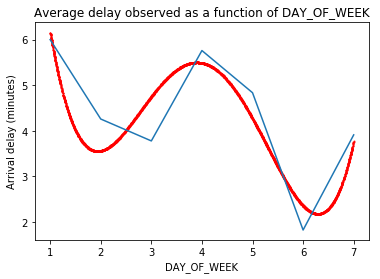

In [57]:
graph_test("DAY_OF_WEEK", polynomial = 4)

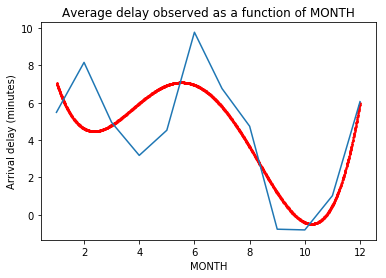

In [58]:
graph_test("MONTH", polynomial = 4)

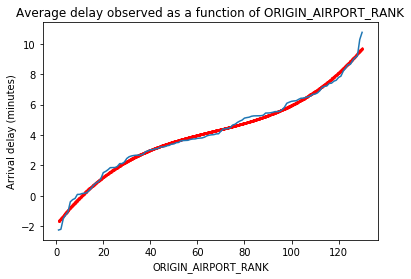

In [59]:
graph_test("ORIGIN_AIRPORT_RANK", polynomial = 3)

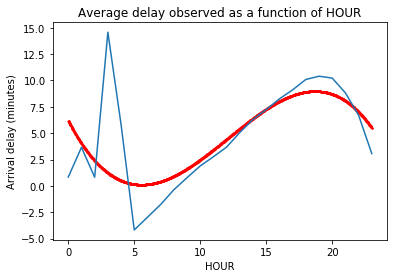

In [60]:
graph_test("HOUR", polynomial = 3)

# 5. Linear regression: predicting the plane delays

## Introduction : splitting the data into a training dataset and a test dataset
From now on, we will split the data into two:
- A training dataset (80% of the data),
- A test dataset (the remainder).

In [61]:
flights_train = flights.sample(frac = 0.8, random_state = 0)
flights_test = flights.drop(flights_train.index)

**Note:** Please note that some of these chunks may take a long time to run.

## 5.1. Numeric regression
First of all, let us define our baseline model and the associated mean squared error.

In [62]:
mean_model = np.mean(flights_train.ARRIVAL_DELAY)

mean_model_mse = sum((mean_model - flights_test.ARRIVAL_DELAY) ** 2)

print('Mean squared error:', mean_model_mse)

Mean squared error: 1572458953.85


We will compare this mean square error to the mean square error of every model that we will create in this section.

We also create the function that will help us generate all the X matrices that we will need for our regression models.

In [63]:
def X_maker(data, **kwargs):
    """
      The aim of the function is to help us build the X matrices that we will use in our regression.
    The argument data should take two possible values: either flights_train, in order to create the
    regression model, or flights_test, so that we can test our regression.
    
      As for the kwargs: the key should take the name of a column, and the value is the degree of the
    polynomial that we want to use for this specific variable in our model.
    """

    X = np.zeros((sum(kwargs.values()) + 1, len(data)))
    X[0] = np.ones(len(data))
    # We set X as a matrix of zeros, and we add a line of (1, 1, ... 1)
    
    ind = 1 # This iterates over all rows of X
    
    for key in kwargs:
        for power in range(1, kwargs[key] + 1):
            X[ind] = np.array(data[key]) ** power
            ind += 1
            
    return(np.transpose(X))

### 5.1.1. Regression with the numeric variables that are directly available to us

In [64]:
X = X_maker(flights_train, MONTH = 1, DAY = 1, SCHEDULED_TIME = 1, DISTANCE = 1, DAY_OF_WEEK = 1, HOUR = 1)

X_test = X_maker(flights_test, MONTH = 1, DAY = 1, SCHEDULED_TIME = 1, DISTANCE = 1,
                 DAY_OF_WEEK = 1, HOUR = 1)

num_model = np.linalg.lstsq(X, np.array(flights_train.ARRIVAL_DELAY))

num_model_mse = sum((np.dot(X_test, num_model[0]) - flights_test.ARRIVAL_DELAY) ** 2)

print('Mean squared error:', num_model_mse)
print('Difference with baseline:', mean_model_mse - num_model_mse)
print('Percentage of accuracy:', str((1 - num_model_mse / mean_model_mse) * 100) + "%")

Mean squared error: 1549809468.68
Difference with baseline: 22649485.171
Percentage of accuracy: 1.44038641616%


### 5.1.2. Regression that includes the categorical variables transformed into numeric variables

In [65]:
X = X_maker(flights_train, MONTH = 1, DAY_OF_WEEK = 1, DAY = 1, HOUR = 1, SCHEDULED_TIME = 1,
           ORIGIN_AIRPORT_RANK = 1, DESTINATION_AIRPORT_RANK = 1, AIRLINE_RANK = 1)

X_test = X_maker(flights_test, MONTH = 1, DAY_OF_WEEK = 1, DAY = 1, HOUR = 1, SCHEDULED_TIME = 1,
           ORIGIN_AIRPORT_RANK = 1, DESTINATION_AIRPORT_RANK = 1, AIRLINE_RANK = 1)

num_cat_model = np.linalg.lstsq(X, np.array(flights_train.ARRIVAL_DELAY))

num_cat_mse = sum((np.dot(X_test, num_cat_model[0]) - flights_test.ARRIVAL_DELAY) ** 2)

print('Mean squared error:', num_cat_mse)
print('Difference with baseline:', mean_model_mse - num_cat_mse)
print('Percentage of accuracy:', str((1 - num_cat_mse / mean_model_mse) * 100) + "%")

Mean squared error: 1539903512.51
Difference with baseline: 32555441.3393
Percentage of accuracy: 2.07035237769%


### 5.1.3. Regression with polynomial support
In this part, we model our delay with polynomial functions of the variables, in an effort to fit the training data more precisely than a strictly linear regression would.

In [66]:
X = X_maker(flights_train, MONTH = 4, DAY = 3, SCHEDULED_TIME = 4, DISTANCE = 3,
           DAY_OF_WEEK = 4, HOUR = 3, ORIGIN_AIRPORT_RANK = 3, DESTINATION_AIRPORT_RANK = 3,
           AIRLINE_RANK = 3)

X_test = X_maker(flights_test, MONTH = 4, DAY = 3, SCHEDULED_TIME = 4, DISTANCE = 3,
           DAY_OF_WEEK = 4, HOUR = 3, ORIGIN_AIRPORT_RANK = 3, DESTINATION_AIRPORT_RANK = 3,
           AIRLINE_RANK = 3)

poly_model = np.linalg.lstsq(X, np.array(flights_train.ARRIVAL_DELAY))

poly_model_mse = sum((np.dot(X_test, poly_model[0]) - flights_test.ARRIVAL_DELAY) ** 2)

print('Mean squared error:', poly_model_mse)
print('Difference with baseline:', mean_model_mse - poly_model_mse)
print('Percentage of accuracy:', str((1 - poly_model_mse / mean_model_mse) * 100) + "%")

Mean squared error: 1529589536.88
Difference with baseline: 42869416.9733
Percentage of accuracy: 2.72626620036%


Again, the accuracy of the model has increased slightly, but not that much.

If we plot the observed delays against the delays predicted by this very last model on the test data, we find the following graphs:

Comparison between observed and predicted delays:


Text(0.5,1,'Same scale for x and y')

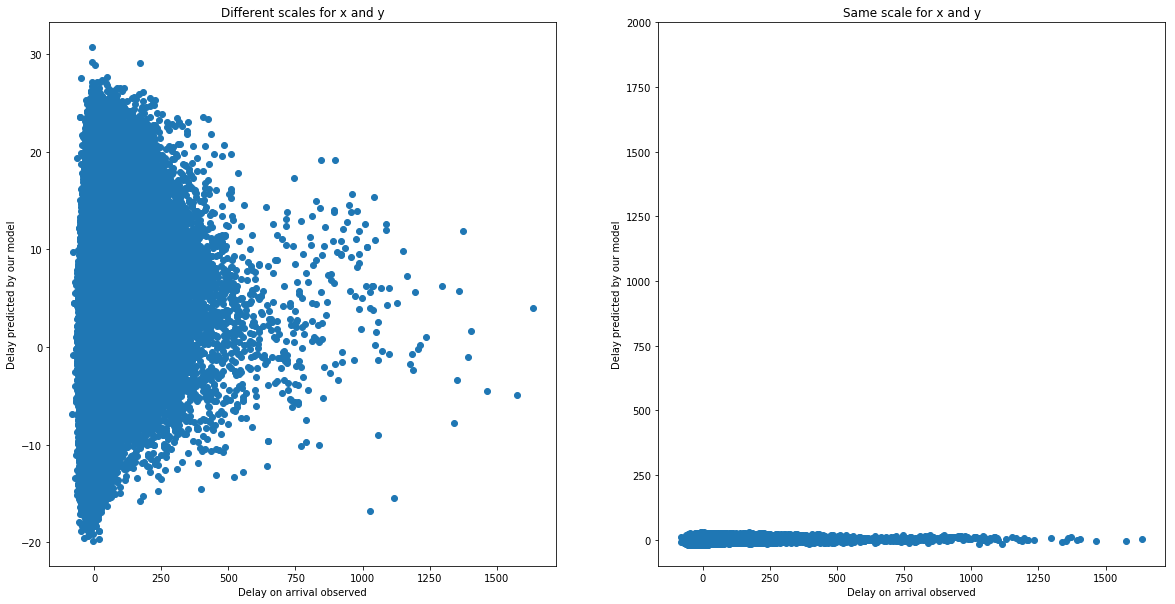

In [67]:
fig, axes = plt.subplots(1,2, figsize = (20, 10))

print('Comparison between observed and predicted delays:')

axes[0].scatter(flights_test.ARRIVAL_DELAY, np.dot(X_test, poly_model[0]))
axes[0].set_xlabel('Delay on arrival observed')
axes[0].set_ylabel('Delay predicted by our model')
axes[0].set_title('Different scales for x and y')

axes[1].scatter(flights_test.ARRIVAL_DELAY, np.dot(X_test, poly_model[0]))
axes[1].set_ylim([-100, 2000])
axes[1].set_xlabel('Delay on arrival observed')
axes[1].set_ylabel('Delay predicted by our model')
axes[1].set_title('Same scale for x and y')

As can be seen on this graph, one shortcoming of our model is that the predicted values are in a much more narrow range than the actual values.

### 5.1.5. Regression by caping the delay at 120 minutes
So far, we have noticed that the range of our predictions is very narrow compared to the actual range of delays. This can be explained by the fact that the range of delays is actually very wide ($[-100, 2000]$). There would be two ways to address the problem:
- Run the regression on a logarithm of the delay instead of the actual delay,
- Cap the maximum amount of delay at a certain value.

The first solution is tempting, but a bit tough to implement, since we have negative values (planes that arrived early). Therefore, we are going to try the second solution, and **cap the maximum amount of delay at 120 minutes**.

In [68]:
flights_train["CAPPED_ARRIVAL_DELAY"] = flights_train.ARRIVAL_DELAY *\
(flights_train.ARRIVAL_DELAY < 180) + 180 * (flights_train.ARRIVAL_DELAY >= 180)

flights_test["CAPPED_ARRIVAL_DELAY"] = flights_test.ARRIVAL_DELAY *\
(flights_test.ARRIVAL_DELAY < 180) + 180 * (flights_test.ARRIVAL_DELAY >= 180)


In this situation, the baseline model becomes:

In [69]:
mean_capped_model = np.mean(flights_train.CAPPED_ARRIVAL_DELAY)

mean_capped_model_mse = sum((mean_capped_model - flights_test.CAPPED_ARRIVAL_DELAY) ** 2)

print('Mean squared error:', mean_capped_model_mse)

Mean squared error: 1096142194.31


And with our previous model, we get:

In [70]:
X = X_maker(flights_train, MONTH = 4, DAY = 3, SCHEDULED_TIME = 4, DISTANCE = 3,
           DAY_OF_WEEK = 4, HOUR = 3, ORIGIN_AIRPORT_RANK = 3, DESTINATION_AIRPORT_RANK = 3,
           AIRLINE_RANK = 3)

X_test = X_maker(flights_test, MONTH = 4, DAY = 3, SCHEDULED_TIME = 4, DISTANCE = 3,
           DAY_OF_WEEK = 4, HOUR = 3, ORIGIN_AIRPORT_RANK = 3, DESTINATION_AIRPORT_RANK = 3,
           AIRLINE_RANK = 3)

poly_capped_model = np.linalg.lstsq(X, np.array(flights_train.CAPPED_ARRIVAL_DELAY))

poly_capped_model_mse = sum((np.dot(X_test, poly_capped_model[0]) - flights_test.CAPPED_ARRIVAL_DELAY) ** 2)

print('Mean squared error:', poly_capped_model_mse)
print('Difference with baseline:', mean_capped_model_mse - poly_capped_model_mse)
print('Percentage of accuracy:', str((1 - poly_capped_model_mse / mean_capped_model_mse) * 100) + "%")

Mean squared error: 1054122308.76
Difference with baseline: 42019885.5518
Percentage of accuracy: 3.83343381635%


### Conclusions for numeric regression
Our efforts so far have not been very conclusive, since even with a modified target, our model is only 4% more precise than the most basic model.

This may be because the most predictive variable (by far) is the departure delay, which we have excluded so far from our analysis. If we include this in a final test, with the initial arrival delay variable, we can see that we can predict delays very accurately:

In [71]:
X = X_maker(flights_train, MONTH = 4, DAY = 3, SCHEDULED_TIME = 4, DISTANCE = 3,
           DAY_OF_WEEK = 4, HOUR = 3, ORIGIN_AIRPORT_RANK = 3, DESTINATION_AIRPORT_RANK = 3,
           AIRLINE_RANK = 3, DEPARTURE_DELAY = 1)

X_test = X_maker(flights_test, MONTH = 4, DAY = 3, SCHEDULED_TIME = 4, DISTANCE = 3,
           DAY_OF_WEEK = 4, HOUR = 3, ORIGIN_AIRPORT_RANK = 3, DESTINATION_AIRPORT_RANK = 3,
           AIRLINE_RANK = 3, DEPARTURE_DELAY = 1)

dep_delay_model = np.linalg.lstsq(X, np.array(flights_train.ARRIVAL_DELAY))

dep_delay_mse = sum((np.dot(X_test, dep_delay_model[0]) - flights_test.ARRIVAL_DELAY) ** 2)

print('Mean squared error:', dep_delay_mse)
print('Difference with baseline:', mean_model_mse - dep_delay_mse)
print('Percentage of accuracy:', str((1 - dep_delay_mse / mean_model_mse) * 100) + "%")

Mean squared error: 163680976.91
Difference with baseline: 1408777976.94
Percentage of accuracy: 89.5907631478%


However, despite its accuracy, this model would not very useful in real life:
- It does not bring a lot of new insight, since it can be expected that a plane that a delay on take-off will result on a similar delay upon landing,
- It depends on information that we can only obtain right before the flight takes off, while we would prefer to make predictions on information we have beforehand.

# 5.1.2. Logistic regression : only focus on whether the plane is late or not

In this final section, we introduce the variable `DELAYED`, that takes the value 1 if the plane has been delayed by 15 minutes or more, 0 otherwise. Our aim will therefore to be to classify flights into two categories:
- Flights that have arrived early or on time,
- Flights that were late.

We will do this with logistic regression.

In [72]:
flights["DEYLAYED"] = flights.ARRIVAL_DELAY > 15
flights_train["DELAYED"] = (flights_train.ARRIVAL_DELAY > 15)
flights_test["DELAYED"] = (flights_test.ARRIVAL_DELAY > 15)

The first step will be to define our baseline model for the logistic regression. In this case, it will be: "Every plane arrives on time".

In [73]:
base_log_model = 0

base_log_perf = sum(flights_test.DELAYED == base_log_model)/len(flights_test)

print('Base model accuracy:', str(base_log_perf * 100) + '%')


Base model accuracy: 81.9166818894%


This model has almost 82% accuracy, and we will be comparing the performance of our models to that baseline.

### 5.2.2. "Basic" logistic regression

"Basic" means that we will not apply any polynomial modifierer to our variables.
For this attempt, we are going to use all numeric variables that were already available in the dataset, plus the categorical variables that were transformed as numeric variables (`ORIGIN_AIRPORT_RANK`, `DESTINATION_AIRPORT_RANK`, and `AIRLINE_RANK`).

In [74]:
X = X_maker(flights_train, MONTH = 1, DAY = 1, SCHEDULED_TIME = 1, DISTANCE = 1,
           DAY_OF_WEEK = 1, HOUR = 1, ORIGIN_AIRPORT_RANK = 1, DESTINATION_AIRPORT_RANK = 1,
           AIRLINE_RANK = 1)

X_test = X_maker(flights_test, MONTH = 1, DAY = 1, SCHEDULED_TIME = 1, DISTANCE = 1,
           DAY_OF_WEEK = 1, HOUR = 1, ORIGIN_AIRPORT_RANK = 1, DESTINATION_AIRPORT_RANK = 1,
           AIRLINE_RANK = 1)

logistic = LogisticRegression()
logistic.fit(X, flights_train.DELAYED)

print('Model accuracy:', str(sum(logistic.predict(X_test) == flights_test.DELAYED)/len(flights_test.DELAYED) * 100) + '%')

Model accuracy: 81.9166818894%


This model has the exact same accuracy as the base model. Besides, if we take a look at the confusion matrix, we can see that they make the same predictions (i.e. they always predict that the plane will be on time).

### 5.2.3. Logistic regression with polynomial degrees

In [75]:
pw = 4

X = X_maker(flights_train, MONTH = pw, DAY = pw, SCHEDULED_TIME = pw, DISTANCE = pw,
           DAY_OF_WEEK = pw, HOUR = pw, ORIGIN_AIRPORT_RANK = pw, DESTINATION_AIRPORT_RANK = pw,
           AIRLINE_RANK = pw)

X_test = X_maker(flights_test, MONTH = pw, DAY = pw, SCHEDULED_TIME = pw, DISTANCE = pw,
           DAY_OF_WEEK = pw, HOUR = pw, ORIGIN_AIRPORT_RANK = pw, DESTINATION_AIRPORT_RANK = pw,
           AIRLINE_RANK = pw)

logistic = LogisticRegression()
logistic.fit(X, flights_train.DELAYED)

print('Model accuracy:', str(sum(logistic.predict(X_test) == flights_test.DELAYED)/len(flights_test.DELAYED) * 100) + '%')

Model accuracy: 81.8760663995%


Despite the added complexity and the better fit of the model, we find that this new model actually performs *worse* than the base model.

### 5.2.4. Logistic regression with one hot encoding

In [76]:
#Set numerical dataset and categorical datset respectively 
sampleflights = flights.sample(frac=1)
num_df = sampleflights[['DURATION','DISTANCE']].astype('float') # Numerical features

categ_df = sampleflights[['DEPARTURE_HOUR','DAY_OF_WEEK','MONTH','ORIGIN_AIRPORT_RANK','DESTINATION_AIRPORT_RANK','AIRLINE_RANK']] #categorical, nostring


# Turn the categorical variable to one hot encoding 
    
encoder = OneHotEncoder() # Create encoder object
categ_df_encoded = encoder.fit_transform(categ_df) 

#since the dataset is massive, have to create array sparse for the numerical ones to combine with categorical one 
num_df_sparse = sparse.csr_matrix(num_df)

# num_df_sparse and categ_df_encoded are sparse matric which can be combined 
x_final=sparse.hstack((num_df_sparse, categ_df_encoded))

In [77]:
# we set dummy variables for ARRIVAL_DELAY
y = sampleflights['ARRIVAL_DELAY'].values
y_final = np.where(y > 15, 1, 0)

In [78]:
x_train, x_test, y_train, y_test = train_test_split(x_final,y_final,test_size = 0.2,random_state = 0) 

model = LogisticRegression(penalty = 'l2', C=1)
model.fit(x_train,y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [79]:
y_pred = model.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.6f}'.format(model.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.819405


In [80]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[843266     14]
 [185848     36]]


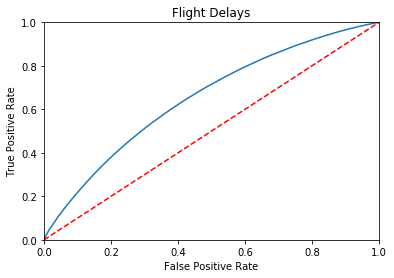

In [81]:
logit_roc_auc = roc_auc_score(y_test, model.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.4f)' % logit_roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Flight Delays')
plt.savefig('Log_ROC')
plt.plot([0, 1], [0, 1],'r--')
plt.show()

We draw the receiver operating characteristic (ROC) curve and find that our classifier is good. The dotted red line represents the ROC curve caused from a random classifier and our classifier (the blue solid line) toward the top-left corner and far away from the red line.

# Conclusion
No matter the technique, the results we obtained from our regressions were generally not that conclusive, with the exception of the models where we included the departure delay as a variable, which greatly reduces the practical interest of such model.

In order to make better predictions, we would need more pieces of external information:
- Weather: It would be much more precise if the model is integrated with weather data since the weather conditions tend to be the most significant factors that influence the departure delay (arrival delay) due to the origin airport (destination airport). 
- Holidays:It is reasonable that airlines are likely to be under stress around holidays, so the model would be more precise with this decent predictor.
- Interaction effects: In practice, the interaction effects between time and weekend, distance and weekend or holiday, etc might be investigated by adding interaction terms in the model.